# Similarity

Illustration of computing similarities between tasks/concepts.

In [1]:
# Settings and imports.
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import product, combinations
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import data

sns.set()
sns.set_context('paper', font_scale=2.0)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Data
tasks = data.load('robomission-2018-02-10/tasks.csv')
ts = data.load('robomission-2018-02-10/task_sessions.csv')
ts = ts[ts.time_spent > 0]
ts = ts.assign(date=ts.end.str[:10])

## Features

In [3]:
def get_token_counts(solution):
    # caveat: 'r' can be either 'right' or 'red' depending on the context
    nesting = 0
    test = False
    counts = defaultdict(int)
    counts = OrderedDict([
        (token, 0)
        for token in ['shoot', 'repeat', 'while', 'if', 'else',
                      'col', 'pos', 'nest']
    ])
    for token in solution:
        if token == '{':
            nesting += 1
            counts['nest'] = max(nesting, counts['nest'])
            test = False
            continue
        if token == '}':
            nesting -= 1
            continue
        if token == 'W':
            counts['while'] += 1
        if token == 'I':
            counts['if'] += 1
        if token == 'R':
            counts['repeat'] += 1
        if token == 's':
            counts['shoot'] += 1
        if token == '/':
            counts['else'] += 1
        if test and token in 'yrgbk':
            counts['col'] += 1
        if test and token == 'x':
            counts['pos'] += 1
        if token in 'WI':
            test = True
    return counts
            

def canonize(letters):
    # canonize wormhole names
    letters = ['W' if letter in 'XYZ' else letter for letter in letters]
    return letters


def get_letter_counts(statement):
    letters = Counter()
    fields = statement['fields']
    for row in fields:
        for _background, objects in row:
            letters.update(canonize(objects))
    return letters


def get_special_color_count(statement):
    fields = statement['fields']
    colors = set()
    for row in fields:
        for background, _objects in row:
            colors.add(background)
    return len(colors) - 2  # don't count black and blue


def get_features(task):
    statement = json.loads(task.setting)
    solution = task.solution
    #print(statement, '\n*\n', solution)
    # statement features
    letter_counts = get_letter_counts(statement)
    features = OrderedDict([
        (letter, letter_counts[letter])
        for letter in 'AMDW'
    ])
    features['Y'] = get_special_color_count(statement)
    features['limit'] = int('length' in statement)
    features['energy'] = int('energy' in statement)
    # solution features
    token_counts = get_token_counts(solution)
    features.update(token_counts)
    return features

RAW_FEATURES = pd.DataFrame.from_records([
    get_features(task) for task in tasks.itertuples()])
STATEMENT_FEATURES = ['A', 'M', 'D', 'W', 'Y', 'limit', 'energy']
SOLUTION_FEATURES = ['shoot', 'repeat', 'while', 'if', 'else', 'col', 'pos', 'nest']
RAW_FEATURES.head()

,A,M,D,W,Y,limit,energy,shoot,repeat,while,if,else,col,pos,nest
0,0,0,8,2,2,1,0,0,2,0,1,1,1,0,3
1,14,0,3,0,1,1,0,0,0,1,1,0,2,0,2
2,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0
3,18,0,0,0,0,1,0,0,0,1,0,0,1,0,1
4,12,3,2,0,0,0,0,3,0,0,0,0,0,0,0


In [7]:
def get_feature_df(which_features='all', transform=None, bias=True):
    """Create a DataFrame with selected and transformed featrues.
    
    Args:
        which_features: {'statement', 'solution', 'all'}
        transform: {'bin', 'log', 'max', 'zscore', 'idf', 'pref', 'regr'}
           - Can be combined, e.g. 'log+idf'.
           - Note that 'none', 'bin', 'log', 'max', 'zscore'
             and their combination are variants of term-frequency;
             see https://en.wikipedia.org/wiki/Tf%E2%80%93idf
             for descriptions.
           - 'idf', 'pref', 'regr' normalize for feature importance
           - Idf is the "common-one": log(N/n), where N
             is the number of all tasks, n is the number of
             tasks containing the feature.
           - 'pref': increase weight for solution features
    """
    # select features
    feature_names = []
    if which_features in {'statement', 'all'}:
        feature_names += STATEMENT_FEATURES
    if which_features in {'solution', 'all'}:
        feature_names += SOLUTION_FEATURES        
    features = RAW_FEATURES[feature_names].copy()    
    # apply transformations
    which_transforms = transform.split('+') if transform else []
    if 'log' in which_transforms:
        features = features.apply(lambda s: np.log(s + 1))
    if 'bin' in which_transforms:
        features = features.apply(lambda s: 0 + (s > 0))
    if 'zscore' in which_transforms:
        features = features.apply(lambda s: (s - s.mean())/s.std(ddof=0))
    if 'max' in which_transforms:
        features = features.apply(lambda s: s / s.max())
    if 'idf' in which_transforms:
        idf = lambda f: (-1) * np.log((f > 0).mean())
        features = features.apply(lambda f: f * idf(f))
    if 'pref' in which_transforms:
        assert which_features in {'solution', 'all'}
        solution_preference = 5
        for f in ['repeat', 'while', 'if', 'else', 'col', 'pos']:
            features[f] *= solution_preference 
    # add bias feature (if a task has all features 0, it has std=0 and correlation is undefined)
    features['bias'] = 1
    return features

FEATURES = get_feature_df(transform='log+max+idf+pref')
FEATURES.head()

,A,M,D,W,Y,limit,energy,shoot,repeat,while,if,else,col,pos,nest,bias
0,0.00,0.00,0.23,0.27,0.86,0.28,0.00,0.00,3.07,0.00,2.04,4.54,1.53,0.00,0.20,1
1,0.50,0.00,0.15,0.00,0.54,0.28,0.00,0.00,0.00,2.04,2.04,0.00,2.42,0.00,0.16,1
2,0.33,0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
3,0.55,0.00,0.00,0.00,0.00,0.28,0.00,0.00,0.00,2.04,0.00,0.00,1.53,0.00,0.10,1
4,0.48,0.46,0.12,0.00,0.00,0.00,0.00,1.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


## Q-matrix

In [58]:
task_names = [
    'three-steps-forward', 'turning-right',
    'ladder', 'stairs',
    'zig-zag', 'stop-on-red',
    'on-yellow-to-left', 'follow-colors']
concepts = [
    'commands', 'repeat', 'while', 'if']

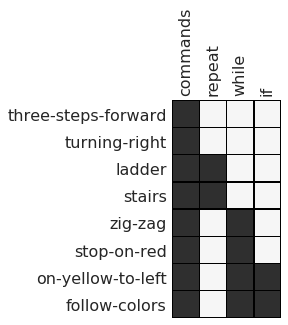

In [62]:
features = FEATURES.set_index(tasks.name)
features = features.assign(commands=1.0)
qmatrix = features.loc[task_names, concepts]
qmatrix_binary = (qmatrix > 0.1).astype(int)
ax = sns.heatmap(
    qmatrix_binary,
    vmin=-0.1, vmax=1.2,
    cbar=False,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cmap='Greys')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
plt.xticks(rotation=90)
ax.figure.savefig('../img/qmatrix-binary.pdf', bbox_inches='tight')

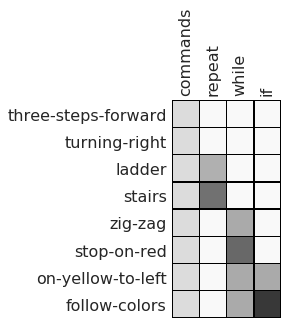

In [64]:
qmatrix_continous = qmatrix / 5
ax = sns.heatmap(
    qmatrix_continous,
    vmin=-0.05, vmax=1,
    cbar=False,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cmap='Greys')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
plt.xticks(rotation=90)
ax.figure.savefig('../img/qmatrix-continuous.pdf', bbox_inches='tight')

## Similarity matrix

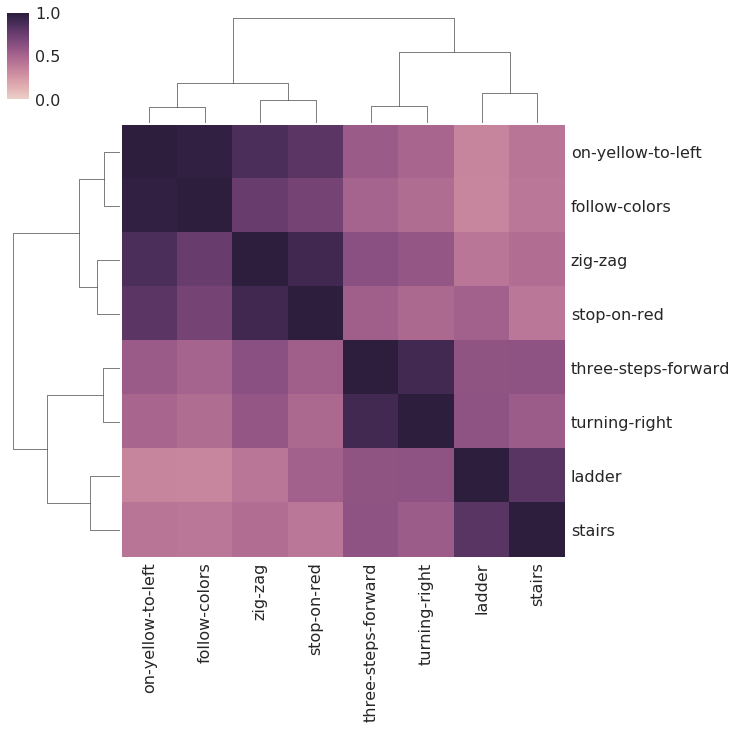

In [93]:
def compute_similarities(feature_df, metric='correlation'):
    """Compute square matrix of distances between columns in feature_df
        (0 = most similar)
    """
    distances = pdist(feature_df.values, metric=metric)
    dist_matrix = squareform(distances)
    # normalize it from 0->2 to 1->0
    dist_matrix = 1 - 0.5 * dist_matrix
    dist_df = pd.DataFrame(
        dist_matrix,
        index=tasks.name,
        columns=tasks.name)
    return dist_df

similarities = compute_similarities(FEATURES)
similarities = similarities.loc[task_names, task_names]
plot = sns.clustermap(
    similarities,
    #annot=True,
    vmin=0, vmax=1,
    cbar_kws={'ticks':[0,0.5,1]},
    cmap=sns.cubehelix_palette(as_cmap=True), # 'Greys'
)
plot.ax_heatmap.set_xlabel('')
plot.ax_heatmap.set_ylabel('')
plot.savefig('../img/similarities-tasks.pdf', bbox_inches='tight')

## Similarity graph

= discretiazation of similarity matrix (leave only the most important edges)

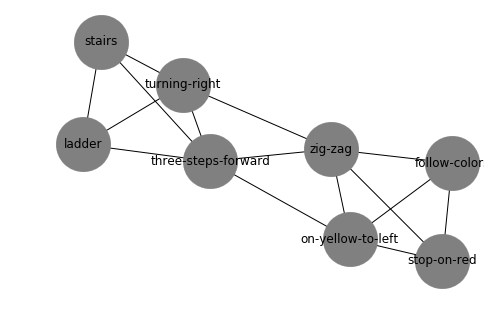

In [114]:
g = nx.Graph()
g.add_nodes_from(task_names)
for t1, t2 in combinations(task_names, r=2):
    w = similarities.loc[t1, t2]
    if w > 0.55:
        g.add_edge(t1, t2)
nx.draw(g, with_labels=True, node_size=3000, node_color='gray')
plt.savefig('../img/similarities-graph.pdf', bbox_inches='tight')

## Correlation between concepts

The following measures how much the concepts occur together (e.g. if and else occur together a lot), but depending on the usage, we probably want a different notion of similarity, e.g. how much similar are distributions of solving times for tasks containing these concepts.

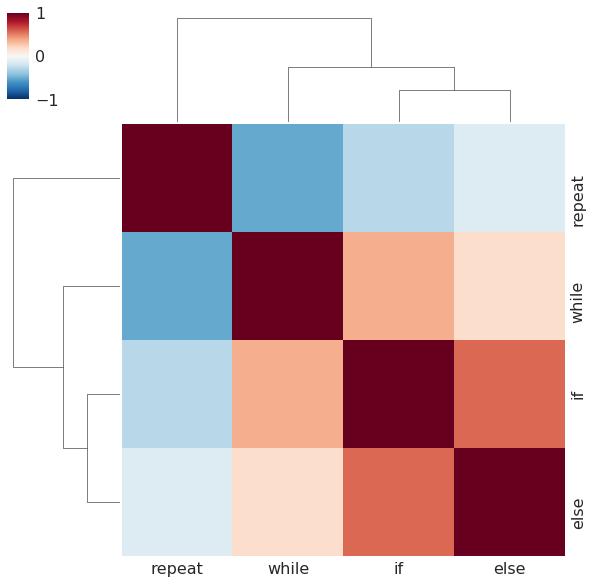

In [82]:
similarities = FEATURES.corr()
concepts = [
    'repeat', 'while', 'if', 'else']
similarities = similarities.loc[concepts, concepts]
plot = sns.clustermap(
    similarities,
    #annot=True,
    vmin=-1, vmax=1,
    cbar_kws={'ticks':[-1,0,1]},
    cmap='RdBu_r'
)
plot.ax_heatmap.set_xlabel('')
plot.ax_heatmap.set_ylabel('')
plot.savefig('../img/similarities-concepts.pdf', bbox_inches='tight')

## Similarities between concepts

TODO